<a href="https://colab.research.google.com/github/stratis-forge/registration-workflows/blob/main/demo_MRI_Pancreas_Fullshot_AnatomicCtxShape_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning-based longitudinal registration and segmentation of abdominal MRI


## Introduction
*  In this tutorial, we  demonstrate how to deploy a pre-trained longitudinal segmentation & registration [model](https://aapm.onlinelibrary.wiley.com/doi/pdf/10.1002/mp.16527) for abdominal MRI  via CERR on a sample  T2 MRI scan

* The model requires the following as inputs: (1) MRI + RTSTRUCT from prev. fraction, rigidly registered to current fraction (2) MRI from current fraction. The RTSTRUCT must include the following structures: `Liver`,`Bowel_lg`,`Bowel_sm`,`Duostomach`


## Requirements

* GNU Octave with `statistics`, `io` & `image` packages for Debian/Linux is distributed via MSKCC Box.

* CERR is downloaded from https://github.com/CERR/cerr

* Python packages: `Oct2py` and `Octave_kernel`, `matplotlib` for visualization

* Pre-trained registration & segmentation model (distributed via MSKCC Box)[https://mskcc.box.com/s/myvwebghpy8so0zfq2eabssjv37m0xbv]

*Tip*: Octave, CERR, and pre-trained model can be saved and loaded from Google Drive to avoid the overhead associated with downloading these dependencies each time the notebook is run.

See [installation instructions](https://github.com/stratis-forge/installation-and-dependencies) for different operating systems.


## Reference
* Jiang, Jue, et al. "Progressively refined deep joint registration segmentation (ProRSeg) of gastrointestinal organs at risk: Application to MRI and cone‐beam CT." Medical Physics (2022)

## Running the notebook
* Please select a runtime with GPU access on the Google Colab platform.
---

## Installation

### Locations of Octave and CERR


In [1]:
# Locations of Octave and CERR
octave_path = '/content/octave'
cerr_path = '/content/CERR'

**Note**: `CERROptions.json` must be edited to set `store_scan_as_mr_philips_precise_value` to `'no'` (off) for proper application of this model.

#### Uncomment (`Ctrl + /`) and evaluate the cell below to download GNU Octave and CERR

In [2]:
# %%capture

# # Download Octave
# oct_build_box = 'https://mskcc.box.com/shared/static/ylfkha0p66oc8v5kh2z1qx9m13n0ijcx.gz'
# oct_save_path = '/content/octave_7.3.0.tar.gz'
# ! wget {oct_build_box} -O {oct_save_path}
# ! tar xf {oct_save_path}
# ! rm {oct_save_path}

# # Download CERR
# ! cd "$(dirname -- "$cerr_path")" && git clone --depth 1 --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git

### Download pretrained model

In [3]:
%%capture

#Model location
AI_model_dir = '/content/pretrained_MRI_reg_seg_model'

#Download conda archive including model weights
MRI_pancreas_model_box = 'https://mskcc.box.com/s/myvwebghpy8so0zfq2eabssjv37m0xbv'

! mkdir {AI_model_dir}
temp_save_path = 'mri_pancreas_reg_seg.tar.gz'
! wget {MRI_pancreas_model_box} -O {temp_save_path}
! tar xf {temp_save_path} -C {AI_model_dir}
! rm {temp_save_path}

#### Install dependencies for GNU Octave and Oct2py bridge


In [4]:
%%capture
# Download dependencies for Using Octave
! apt-get update
! cd /usr/lib/x86_64-linux-gnu/ && ln -s libhdf5_serial.so.103 libhdf5_serial.so.100 && ln -s libreadline.so.8 libreadline.so.7
! apt-get install libgraphicsmagick++-q16-12 libcholmod3 libcxsparse3 \
libumfpack5 libspqr2 libqrupdate1 libfftw3-3 libgfortran4 gnuplot openjdk-8-jdk

# Set path to Octave exectuable
import os, urllib.request, json
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']

# Install oct2py bridge for Python-Octave communication
! pip3 install octave_kernel
! pip3 install oct2py==5.6.0

# Enable Octave magic
%load_ext oct2py.ipython

In [5]:
%%capture
%%octave
pkg load image
pkg load io
pkg load statistics

## Longitudinal MRI registration and segmenation

In [6]:
%%capture
input_dcm_dir = '/content/dcm_in';           #Replace with path to i/p DICOM data
output_dcm_dir = '/content/results/Dcm';     #Replace with path to o/p DICOM data
output_nii_dir = '/content/results/Nii';     #Model config file must be edited to
                                             #point to this directory

**Note**: `MRI_Pancreas_Fullshot_AnatomicCtxShape_v1_config.json` distributed with CERR must be edited
so that output DVF location (`'outputDir'`) matches `output_nii_dir` above.

In [7]:
%octave_push cerr_path AI_model_dir input_dcm_dir output_dcm_dir

In [8]:
%%capture
%%octave

# Add CERR to Octave path
curr_dir = pwd();
cd(cerr_path)
addToPath2(cerr_path)
cd(curr_dir)

init_ML_DICOM

#Run segmentation model
algorithm = 'MRI_Pancreas_Fullshot_AnatomicCtxShape_v1';
sessionPath = '/content/temp_session';
cmdFlag = 'condaEnv';

#For octave use:
inputS.scan.scanNum = [1,2];
outScanNum = 2;

success =  runAIforDicom(input_dcm_dir,output_dcm_dir,...
sessionPath,algorithm,cmdFlag,'yes',AI_model_dir,inputS,outScanNum,false);

## Apply AI-generated DVF using Plastimatch

Convert input scans to NII format

In [9]:
input_base_dcm = input_dcm_dir + '/followup'                          #Replace'followup' with name of sub-dir containing longitudinal scan
input_mov_dcm = input_dcm_dir + '/baseline'                           #Replace 'baseline' with name of sub-dir with baseline scan

conv_base_nii = output_nii_dir + '/baseScan.nii'
conv_mov_nii = output_nii_dir + '/movScan.nii'
warped_input_nii = output_nii_dir + '/warpedScan.nii'

AI_dvf_filename = 'cerrFile^sample_pt_1_MR_DVF_first_scan_3D.nii.gz'  #Replace with o/p filename
in_dvf_path = output_nii_dir + '/' + AI_dvf_filename

In [10]:
%%capture
%%bash -s {input_base_dcm} {conv_base_nii}
plastimatch convert --input $1 \
--output-img $2

In [11]:
%%capture
%%bash -s {input_mov_dcm} {conv_mov_nii}
plastimatch convert --input $1 \
--output-img $2

Apply DVF to warp moving scan

In [12]:
%%bash -s {conv_mov_nii} {warped_input_nii} {in_dvf_path} {conv_base_nii}
plastimatch warp \
  --input $1 \
  --output-img $2 \
  --xf $3 \
  --fixed $4

Loading xform (/cluster/home/iyera/temp/outNii/cerrFile^sample_pt_1_MR_DVF_first_scan_3D.nii.gz)
Setting PIH from FIXED
PIH is:
Origin = -219.503 -230.5 -124
Size = 448 448 125
Spacing = 1 1 2
Direction = 1 0 -2.35934e-05 0 1 0 2.35934e-05 0 1
Rt_study_warp: Warping m_img
plm_warp_itk: xform_to_itk_vf
plm_warp_itk: convert_to_itk
plm_warp_itk: warping...
Rt_study_warp: Saving m_img (/cluster/home/iyera/temp/outNii/warpedScan.nii)
Trying to write image to /cluster/home/iyera/temp/outNii/warpedScan.nii
Rt_study_warp: warp and save ss.
Finished!


### DICOM conversion`

Uncomment the cells below to create a REG dicom-format DVF file

In [13]:
# %octave_push input_base_dcm input_mov_dcm in_dvf_path


In [14]:
# %%octave

# out_reg_file = fullfile(output_dcm_dir,'ai_test.dcm');

# activate_cmd = sprintf(['/bin/bash -c "source %s/bin/activate'],AI_model_dir);
# reg2dcm_cmd = sprintf(['python /cluster/home/clinSegData/container_builds/dev/MRI_Pancreas_Fullshot_AnatomicCtxShape_v2/',...
# 'condaenv/reg2dcm/reg2dcm.py -b %s -m %s -d %s -o %s"'],input_base_dcm,input_mov_dcm,in_dvf_path,out_reg_file);

# system([activate_cmd, ' && ', reg2dcm_cmd])

## Visualizing model outputs

In [15]:
import SimpleITK as sitk

base_img = sitk.ReadImage(conv_base_nii)
base_arr = sitk.GetArrayFromImage(base_img)
img_ori = base_img.GetDirection()
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img_ori))

moving_img = sitk.ReadImage(conv_mov_nii)
moving_arr = sitk.GetArrayFromImage(moving_img)
img_ori = moving_img.GetDirection()
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img_ori))

warped_img = sitk.ReadImage(warped_input_nii)
warped_arr = sitk.GetArrayFromImage(warped_img)
img_ori = warped_img.GetDirection()
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img_ori))

dvf_img = sitk.ReadImage(in_dvf_path)
dvf_arr = sitk.GetArrayFromImage(dvf_img)
img_ori = dvf_img.GetDirection()
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img_ori))

# # Correct orientation from LAS to LPS if required
dvf_flip_image = sitk.DICOMOrient(dvf_img,"LPS")
img_ori = dvf_flip_image.GetDirection()
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(img_ori))
dvf_flip_arr = sitk.GetArrayFromImage(dvf_flip_image)

## Visualizing model outputs

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 447, dx)
y = np.arange(0, 447, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

clear_output(wait=True)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max

    return window_image

Slice 30


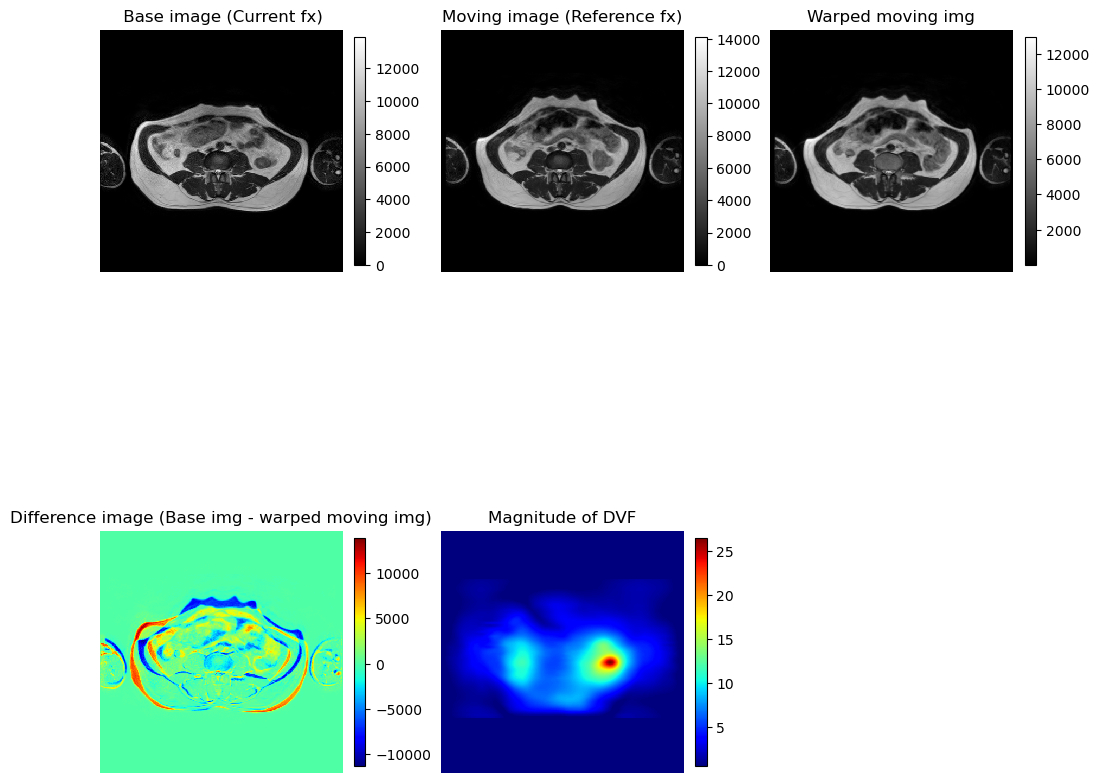

In [18]:
from matplotlib.gridspec import GridSpec

def show_axial_slice(slcNum):
    clear_output(wait=True)
    print('Slice '+str(slcNum))
    if 'fig' in locals():
        fig.remove()
    fig = plt.figure(constrained_layout=True,figsize=(10,10))
    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])


    #Display base img
    base_min = np.min(base_arr)
    base_max = np.max(base_arr)
    window_center = (base_min + base_max)/2
    window_width = base_max - base_min
    windowed_img = window_image(base_arr[slcNum-1,:,:],
                                window_center,window_width)
    im1 = ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    ax1.axis('off')
    ax1.title.set_text(" Base image (""Current fx"")")
    cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.047)


    #Display moving img (orig)
    mov_min = np.min(moving_arr)
    mov_max = np.max(moving_arr)
    window_center = (mov_min + mov_max)/2
    window_width = mov_max - mov_min
    windowed_img = window_image(moving_arr[slcNum-1,:,:],
                                window_center,window_width)
    im2 = ax2.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                     interpolation='nearest', extent=extent)
    ax2.title.set_text("Moving image (""Reference fx"")")
    ax2.axis('off')
    cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.047)


    #Display moving img (warped)
    warp_min = np.min(warped_arr)
    warp_max = np.max(warped_arr)
    window_center = (warp_min + warp_max)/2
    window_width = warp_max - warp_min

    windowed_img = window_image(warped_arr[slcNum-1,:,:],
                                window_center,window_width)
    im3 = ax3.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    ax3.axis('off')
    ax3.title.set_text("Warped moving img")
    cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.047)

    #Display diff img (warped)
    diff_arr = base_arr - warped_arr
    diff_min = np.min(diff_arr)
    diff_max = np.max(diff_arr)
    window_center = (diff_min + diff_max)/2
    window_width = diff_max - diff_min

    windowed_img = window_image(diff_arr[slcNum-1,:,:],
                                window_center,window_width)
    im4 = ax4.imshow(windowed_img, cmap=plt.cm.jet, alpha=1,
                    interpolation='nearest', extent=extent)
    ax4.axis('off')
    ax4.title.set_text("Difference image (Base img - warped moving img)")
    cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.047)

    #Display dvf mag
    dx = dvf_flip_arr[:,:,:,0]
    dy = dvf_flip_arr[:,:,:,1]
    dz = dvf_flip_arr[:,:,:,2]
    dvf_mag = np.sqrt(np.square(dx) + np.square(dy) + np.square(dz))
    #dvf_mag = dz
    dvf_mag_min = np.min(dvf_mag)
    dvf_mag_max = np.max(dvf_mag)
    window_center = (dvf_mag_min + dvf_mag_max)/2
    window_width = dvf_mag_max - dvf_mag_min
    windowed_img = window_image(dvf_mag[slcNum-1,:,:],
                                window_center,window_width)
    im5 = ax5.imshow(windowed_img, cmap=plt.cm.jet, alpha=1,
                    interpolation='nearest', extent=extent)
    ax5.axis('off')
    ax5.title.set_text("Magnitude of DVF")
    cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.047)


    plt.show()

slice_slider = widgets.IntSlider(value=30,min=1,max=79,step=1)
outputSlc = widgets.Output()

display(slice_slider, outputSlc)


def update_slice(change):
    with outputSlc:
        show_axial_slice(change['new'])

slice_slider.observe(update_slice, names='value')